<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Ecorces_Arbres/IdEcorces-ResConv-Transfert-Colab" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

SVP, déployez toutes les cellules en sélectionnant l'item « Développer les rubriques » de l'onglet « Affichage ».

# Identification d'arbres à partir de leur écorce

## Réseau convolutif avec apprentissage par transfert et peaufinage

### Inspiration et droits d'auteur

Ce laboratoire s'inspire de plusieurs oeuvres en logiciels libres qui ont été transformées dont:

<a href="https://www.tensorflow.org/tutorials/images/transfer_learning" target='_blank'>Transfer learning and fine-tuning</a> - site Google / Tutoriels TensorFlow

##### Copyright (c) 2017, François Chollet  
##### Copyright (c) 2019-2022, The TensorFlow Authors.
##### Copyright (c) 2022, Claude Coulombe

Le contenu de cette page est sous licence <a href="https://creativecommons.org/licenses/by/4.0/deed.fr" target='_blank'>Creative Commons Attribution 4.0 (CC BY 4.0)</a>,<br/>et les exemples de code sont sous <a href="https://www.apache.org/licenses/LICENSE-2.0" target='_blank'>licence Apache 2.0</a>.

#### Données

Les données sur les écorces d'arbres proviennent de <a href="https://data.mendeley.com/research-data/?search=barknet">BarkNet</a>, une banque en données ouvertes sous licence MIT de 23 000 photos d'écorces d'arbres en haute résolution prises avec des téléphones intelligents par une équipe d'étudiants et de chercheurs du <a href="https://www.sbf.ulaval.ca/" target='_blank'>Département des sciences du bois et de la forêt de l'Université Laval</a> à Québec.</p>

# Apprentissage par transfert & peaufinage

## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
**Note** : Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [ ]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 42

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)

# Note: Retrait du comportement déterministe
# à cause de keras.layers.RandomContrast(...)
# dont il n'existe pas de version déterministe
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

## Acquisition des données

Notez qu'en raison, des limites imposées par Colab, nous avons échantillonné 1.5 Go de données sur les 32 Go de données initiales de BarkNet.

Aussi, nous n'avons pas inclus Acer platanoides (2), Pinus rigida (15) et Populus grandidentata (18) car il n'y avait pas suffisamment d'images dans ces classes pour obtenir des résultats significatifs.

In [ ]:
dict_arbres = {
    'BOJ' : "Betula alleghaniensis - Bouleau jaune - Yellow birch",
    'BOP' : "Betula papyrifera - Bouleau à papier - White birch",
    'CHR' : "Quercus rubra - Chêne rouge - Northern red oak",
    'EPB' : "Picea glauca - Épinette blanche - White spruce",
    'EPN' : " Picea mariana - Épinette noire - Black spruce",
    'EPO' : "Picea abies - Épinette de Norvège - Norway spruce",
    'EPR' : "Picea rubens - Épinette rouge - Red spruce",
    'ERR' : "Acer rubrum - Érable rouge - Red maple",
    'ERS' : "Acer saccharum - Érable à sucre - Sugar maple",
    'FRA' : "Fraxinus americana - Frêne d'Amérique - White ash",
    'HEG' : "Fagus grandifolia - Hêtre à grandes feuilles - American beech",
    'MEL' : "Larix laricina - Mélèze - Tamarack",
    'ORA' : "Ulmus americana - Orme d'Amérique - American elm",
    'OSV' : "Ostrya virginiana - Ostryer de Virginie - American hophornbeam",
    'PET' : "Populus tremuloides - Peuplier faux tremble - Quaking aspen",
    'PIB' : "Pinus strobus - Pin blanc - Eastern white pine",
    'PIR' : "Pinus resinosa - Pin rouge - Red pine",
    'PRU' : "Tsuga canadensis - Pruche du Canada - Eastern Hemlock",
    'SAB' : "Abies balsamea - Sapin Baumier - Balsam fir",
    'THO' : "Thuja occidentalis - Thuya occidental - Northern white cedar",
}

print("Dictionnaire mémorisé")

### Création des répertoires de données

Nous allons créer un répertoire de base `donnees`, un répertoire `lab_ecorces` où les données seront réparties en données d'entraînement, de validation et de test pour chaque classe cible.

Enfin, un répertoire `modeles` pour mémoriser les modèles une fois entraînés.

In [ ]:
try:
    os.mkdir("/content/donnees/")
except OSError:
    pass
try:
    os.mkdir("/content/lab_ecorces/")
except OSError:
    pass
try:
    os.mkdir("/content/modeles/")
except OSError:
    pass

### Téléchargement des données depuis le site de Kaggle

0. Téléchargez les données archive.zip sur votre poste local à partir du site Kaggle:<br/>
https://www.kaggle.com/claudecoulombe/ecorces-darbres-jeu-de-donnees-reduit

<img src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Kaggle-Donnees-Ecorces.png"/>

1. Maintenant, téléversez les données de votre poste local à l'environnement Colab.

<img src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Colab_Importer_Fichier.png"/>

2. La fenêtre de l'outil de fichiers de votre ordinateur s'ouvre alors. Allez chercher les données archive.zip que vous avez sauvegardé sur votre ordinateur local.
    
    Attention! Assurez-vous que le fichier archive.zip est entièrement téléversé et que l'icône d'état du téléversement (un cercle jaune) disparaisse avant de décompresser le fichier. 

<img style="margin-left:40px;" src="https://cours.edulib.org/asset-v1:Cegep-Matane+VAERN.1FR+P2021+type@asset+block@Colab_Importer_Fichier-4.png"/>

3. Décompressez le fichier archive.zip en exécutant la commande ci-dessous:

In [9]:
!unzip /content/archive.zip -d /content/data && rm /content/archive.zip

Archive:  /content/archive.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/archive.zip or
        /content/archive.zip.zip, and cannot find /content/archive.zip.ZIP, period.


In [10]:
# Demande d'autorisation pour télécharger les données sur Google Drive 
# Référence: https://colab.research.google.com/notebooks/io.ipynb

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import shutil
import zipfile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [14]:
url_donnees_GDrive = "https://drive.google.com/file/d/1M0l-CWV1YGaYDgyhZ8QXNdtjfkOxKYgU/view?usp=sharing"
id_fichier = url_donnees_GDrive.split('/')[5]
fichier = drive.CreateFile({'id':id_fichier})
nom_fichier = "archive.zip"
# télécharger le fichier nom_fichier
fichier.GetContentFile("/content/donnees/" + nom_fichier)
print("Fichier " + nom_fichier + " téléchargé")
zip_ref = zipfile.ZipFile("/content/donnees/" + nom_fichier, 'r')
zip_ref.extractall("/content/donnees")
zip_ref.close()
print("Fichier " + nom_fichier + " décompressé")
try:
  os.remove("/content/donnees/"+nom_fichier)
  print("Fichier " + nom_fichier + " effacé")
except:
  print("?")

Fichier archive.zip téléchargé
Fichier archive.zip décompressé
Fichier archive.zip effacé


### Répartition des données

In [15]:
# Installation des bibliothèques Python `split-folders` et `tqdm`
!pip3 install split-folders tqdm

In [20]:
# Répartition des données d'entraînement, de validation et de tests
import splitfolders
import pathlib

#### répertoire des données en entrée et des données une fois réparties
repertoire_entree = "/content/donnees/ecorces_arbres_qc_donnees_reduites"
repertoire_donnees_reparties = "/content/lab_ecorces"
# => train, val, test

nombre_images = len(list(pathlib.Path(repertoire_entree).glob('*/*.jpg')))
print("Nombre total d'images:",nombre_images)

splitfolders.ratio(repertoire_entree, 
                   output=repertoire_donnees_reparties, 
                   seed=42, 
                   ratio = (0.80, 0.15, 0.05))

print("\nRépartition des données terminée!")


Nombre total d'images: 3981


Copying files: 3981 files [00:09, 438.01 files/s]


Répartition des données terminée!


### Visualisation d'un échantillon des données

__________________________________________________________________________________________
BOJ  Bouleau jaune 
/content/lab_ecorces/train/BOJ/459_BOJ_57_GalaxyS5_20170607_141946_28.jpg
/content/lab_ecorces/train/BOJ/27_BOJ_74_Nexus 5_20170804_100845_5.jpg
/content/lab_ecorces/train/BOJ/643_BOJ_79_GalaxyS5_20170615_111711_11.jpg
/content/lab_ecorces/train/BOJ/639_BOJ_80_GalaxyS5_20170615_103720_10.jpg


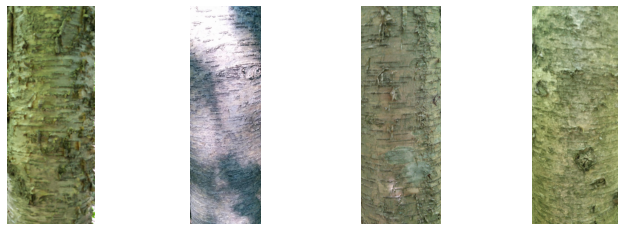

__________________________________________________________________________________________
BOP  Bouleau à papier 
/content/lab_ecorces/train/BOP/465_BOP_55_GalaxyS5_20170607_140839_18.jpg
/content/lab_ecorces/train/BOP/32_BOP_65_Nexus 5_20170608_090244_6.jpg
/content/lab_ecorces/train/BOP/468_BOP_60_GalaxyS7_20170607_145530_39.jpg
/content/lab_ecorces/train/BOP/472_BOP_48_GalaxyS7_20170607_153902_16.jpg


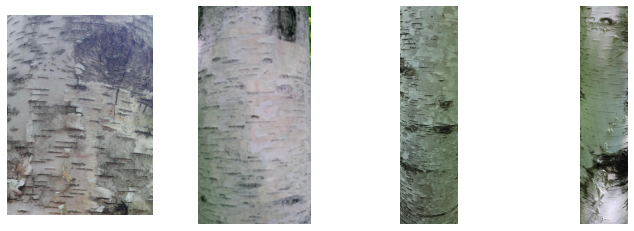

__________________________________________________________________________________________
CHR  Chêne rouge 
/content/lab_ecorces/train/CHR/522_CHR_114_GalaxyS7_20170916_182423_3.jpg
/content/lab_ecorces/train/CHR/484_CHR_201_GalaxyS7_20170916_150524_20.jpg
/content/lab_ecorces/train/CHR/50_CHR_64_Nexus 5_20170906_092340_8.jpg
/content/lab_ecorces/train/CHR/80_CHR_62_Nexus 5_20170906_105412_16.jpg


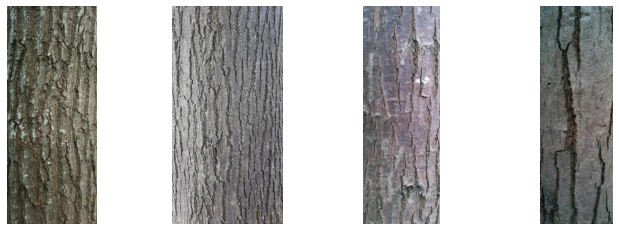

__________________________________________________________________________________________
EPB  Épinette blanche 
/content/lab_ecorces/train/EPB/87_EPB_91_Nexus 5_20170817_110708_4.jpg
/content/lab_ecorces/train/EPB/691_EPB_57_GalaxyS5_20170712_123226_10.jpg
/content/lab_ecorces/train/EPB/84_EPB_100_Nexus 5_20170817_110117_9.jpg
/content/lab_ecorces/train/EPB/82_EPB_90_Nexus 5_20170817_105916_11.jpg


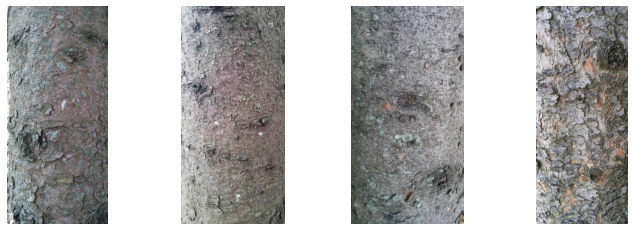

__________________________________________________________________________________________
EPN  Épinette noire 
/content/lab_ecorces/train/EPN/723_EPN_73_GalaxyS5_20170622_111138_7.jpg
/content/lab_ecorces/train/EPN/704_EPN_105_GalaxyS5_20170622_101835_16.jpg
/content/lab_ecorces/train/EPN/727_EPN_90_GalaxyS5_20170622_112107_4.jpg
/content/lab_ecorces/train/EPN/720_EPN_81_GalaxyS5_20170622_110522_4.jpg


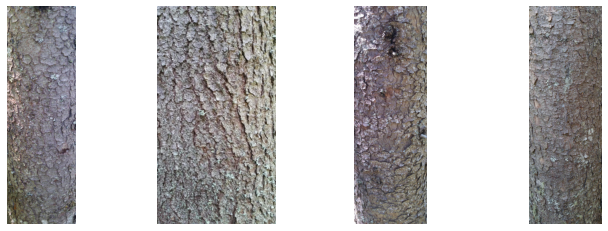

__________________________________________________________________________________________
EPO  Épinette de Norvège 
/content/lab_ecorces/train/EPO/131_EPO_90_Nexus 5_20170921_152211_17.jpg
/content/lab_ecorces/train/EPO/157_EPO_40_Nexus 5_20170922_100025_3.jpg
/content/lab_ecorces/train/EPO/743_EPO_77_GalaxyS5_20170615_101259_15.jpg
/content/lab_ecorces/train/EPO/741_EPO_95_GalaxyS5_20170615_101038_12.jpg


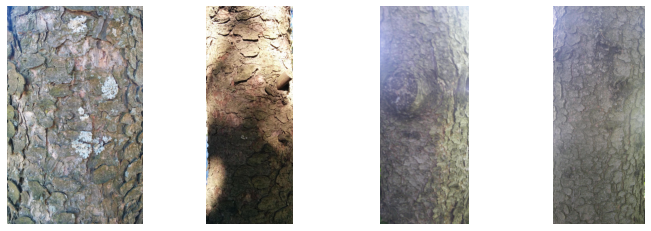

__________________________________________________________________________________________
EPR  Épinette rouge 
/content/lab_ecorces/train/EPR/177_EPR_87_Nexus 5_20170608_102305_10.jpg
/content/lab_ecorces/train/EPR/539_EPR_83_GalaxyS5_20170607_153802_8.jpg
/content/lab_ecorces/train/EPR/536_EPR_42_GalaxyS7_20170607_143733_14.jpg
/content/lab_ecorces/train/EPR/178_EPR_100_Nexus 5_20170608_102414_8.jpg


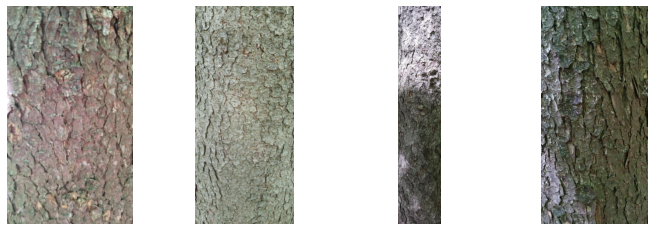

__________________________________________________________________________________________
ERR  Érable rouge 
/content/lab_ecorces/train/ERR/767_ERR_63_GalaxyS5_20170706_122640_6.jpg
/content/lab_ecorces/train/ERR/203_ERR_57_Nexus 5_20170804_112024_2.jpg
/content/lab_ecorces/train/ERR/761_ERR_95_GalaxyS5_20170615_111207_16.jpg
/content/lab_ecorces/train/ERR/767_ERR_63_GalaxyS5_20170706_122640_2.jpg


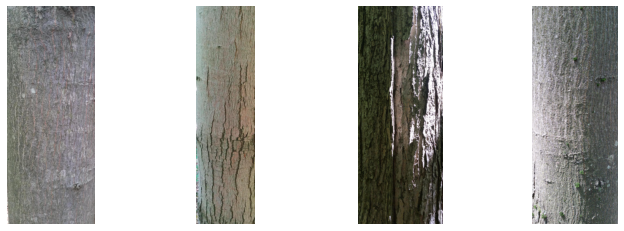

__________________________________________________________________________________________
ERS  Érable à sucre 
/content/lab_ecorces/train/ERS/589_ERS_28_GalaxyS7_20170920_170726_15.jpg
/content/lab_ecorces/train/ERS/771_ERS_88_GalaxyS5_20170615_112622_5.jpg
/content/lab_ecorces/train/ERS/214_ERS_146_Nexus 5_20170804_091438_7.jpg
/content/lab_ecorces/train/ERS/222_ERS_122_Nexus 5_20170804_093229_6.jpg


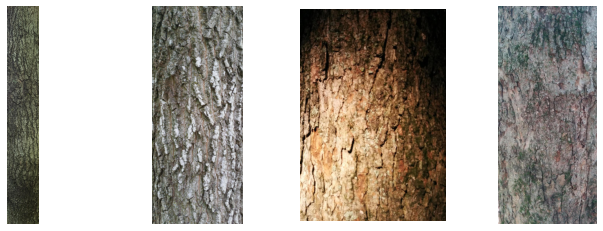

__________________________________________________________________________________________
FRA  Frêne d'Amérique 
/content/lab_ecorces/train/FRA/266_FRA_120_Nexus 5_20170804_103351_2.jpg
/content/lab_ecorces/train/FRA/258_FRA_105_Nexus 5_20170804_102256_3.jpg
/content/lab_ecorces/train/FRA/599_FRA_121_GalaxyS5_20170607_140207_51.jpg
/content/lab_ecorces/train/FRA/19_FRA_134_Lumix_20170804_095034_2.jpg


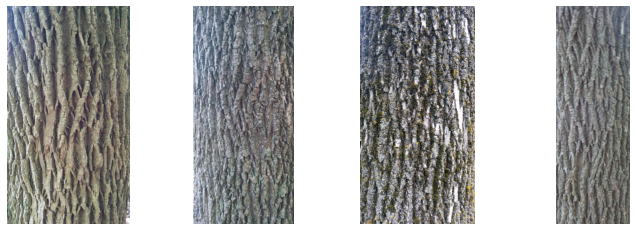

__________________________________________________________________________________________
HEG  Hêtre à grandes feuilles 
/content/lab_ecorces/train/HEG/798_HEG_88_GalaxyS5_20170713_101954_15.jpg
/content/lab_ecorces/train/HEG/276_HEG_53_Nexus 5_20170608_091620_3.jpg
/content/lab_ecorces/train/HEG/278_HEG_112_Nexus 5_20170608_100456_3.jpg
/content/lab_ecorces/train/HEG/623_HEG_86_GalaxyS7_20170916_180146_11.jpg


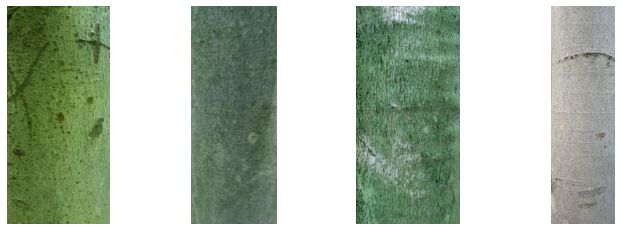

__________________________________________________________________________________________
MEL  Mélèze 
/content/lab_ecorces/train/MEL/838_MEL_65_GalaxyS5_20170706_110605_21.jpg
/content/lab_ecorces/train/MEL/833_MEL_122_GalaxyS5_20170706_105828_19.jpg
/content/lab_ecorces/train/MEL/808_MEL_82_GalaxyS5_20170622_093519_9.jpg
/content/lab_ecorces/train/MEL/835_MEL_63_GalaxyS5_20170706_110140_3.jpg


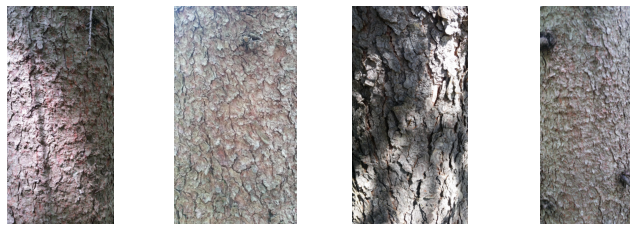

__________________________________________________________________________________________
ORA  Orme d'Amérique 
/content/lab_ecorces/train/ORA/290_ORA_122_Nexus 5_20170810_105157_9.jpg
/content/lab_ecorces/train/ORA/287_ORA_52_Nexus 5_20170810_104629_10.jpg
/content/lab_ecorces/train/ORA/301_ORA_124_Nexus 5_20170810_120937_3.jpg
/content/lab_ecorces/train/ORA/882_ORA_85_GalaxyS5_20170712_113238_28.jpg


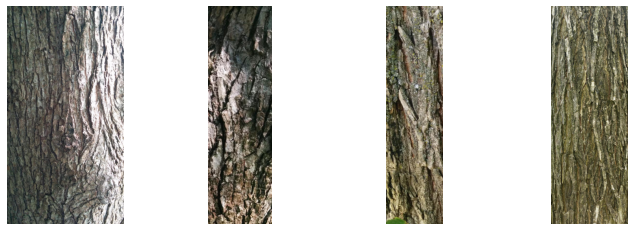

__________________________________________________________________________________________
OSV  Ostryer de Virginie 
/content/lab_ecorces/train/OSV/886_OSV_80_GalaxyS5_20170713_104000_9.jpg
/content/lab_ecorces/train/OSV/900_OSV_46_GalaxyS5_20170713_122523_14.jpg
/content/lab_ecorces/train/OSV/303_OSV_61_Nexus 5_20170804_101215_5.jpg
/content/lab_ecorces/train/OSV/307_OSV_64_Nexus 5_20170906_103508_19.jpg


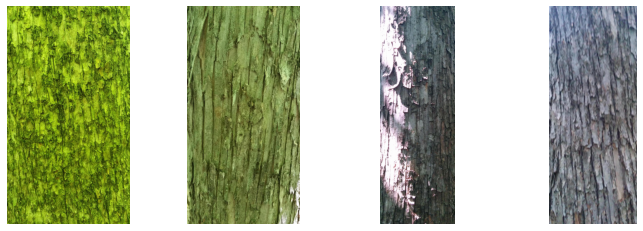

__________________________________________________________________________________________
PET  Peuplier faux tremble 
/content/lab_ecorces/train/PET/936_PET_64_GalaxyS5_20170712_111947_20.jpg
/content/lab_ecorces/train/PET/932_PET_80_GalaxyS5_20170712_110606_18.jpg
/content/lab_ecorces/train/PET/935_PET_80_GalaxyS5_20170712_111735_4.jpg
/content/lab_ecorces/train/PET/909_PET_89_GalaxyS5_20170712_101809_15.jpg


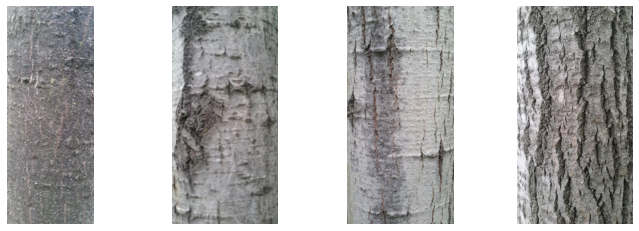

__________________________________________________________________________________________
PIB  Pin blanc 
/content/lab_ecorces/train/PIB/326_PIB_85_Nexus 5_20170615_124520_14.jpg
/content/lab_ecorces/train/PIB/966_PIB_87_GalaxyS5_20170615_130937_18.jpg
/content/lab_ecorces/train/PIB/330_PIB_96_Nexus 5_20170615_125105_18.jpg
/content/lab_ecorces/train/PIB/340_PIB_119_Nexus 5_20170615_135514_11.jpg


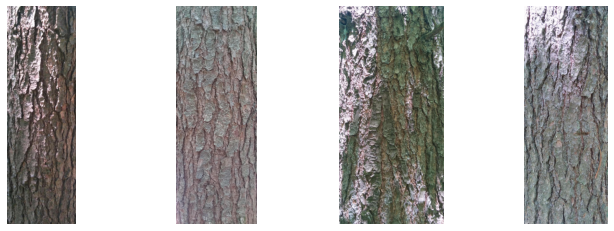

__________________________________________________________________________________________
PIR  Pin rouge 
/content/lab_ecorces/train/PIR/366_PIR_90_Nexus 5_20170817_113841_2.jpg
/content/lab_ecorces/train/PIR/374_PIR_98_Nexus 5_20170817_114426_4.jpg
/content/lab_ecorces/train/PIR/360_PIR_103_Nexus 5_20170817_111914_7.jpg
/content/lab_ecorces/train/PIR/358_PIR_88_Nexus 5_20170817_110336_18.jpg


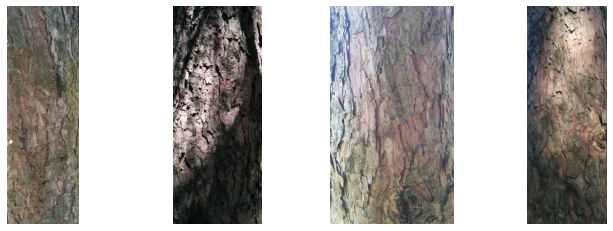

__________________________________________________________________________________________
PRU  Pruche du Canada 
/content/lab_ecorces/train/PRU/404_PRU_99_Nexus 5_20170906_092848_13.jpg
/content/lab_ecorces/train/PRU/979_PRU_111_GalaxyS5_20170713_115032_32.jpg
/content/lab_ecorces/train/PRU/974_PRU_136_GalaxyS5_20170615_115858_15.jpg
/content/lab_ecorces/train/PRU/393_PRU_104_Nexus 5_20170906_091302_18.jpg


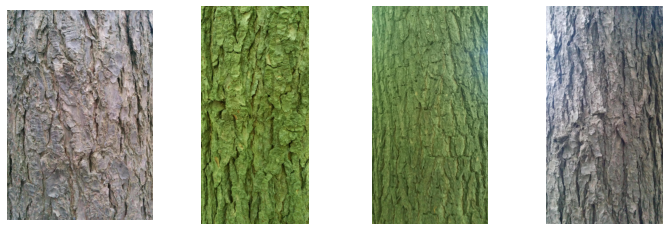

__________________________________________________________________________________________
SAB  Sapin Baumier 
/content/lab_ecorces/train/SAB/980_SAB_56_GalaxyS5_20170615_105130_20.jpg
/content/lab_ecorces/train/SAB/984_SAB_74_GalaxyS5_20170615_134751_18.jpg
/content/lab_ecorces/train/SAB/989_SAB_70_GalaxyS5_20170622_091418_15.jpg
/content/lab_ecorces/train/SAB/417_SAB_61_Nexus 5_20170608_104003_15.jpg


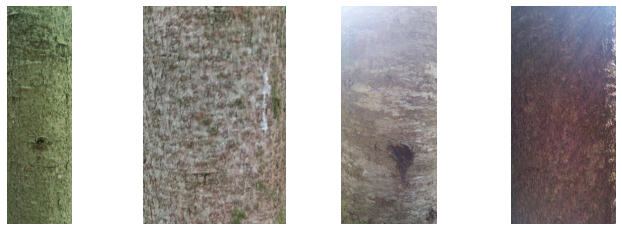

__________________________________________________________________________________________
THO  Thuya occidental 
/content/lab_ecorces/train/THO/431_THO_60_Nexus 5_20170615_134430_3.jpg
/content/lab_ecorces/train/THO/434_THO_57_Nexus 5_20170810_101215_4.jpg
/content/lab_ecorces/train/THO/441_THO_108_Nexus 5_20170810_102111_7.jpg
/content/lab_ecorces/train/THO/456_THO_119_Nexus 5_20170810_104123_10.jpg


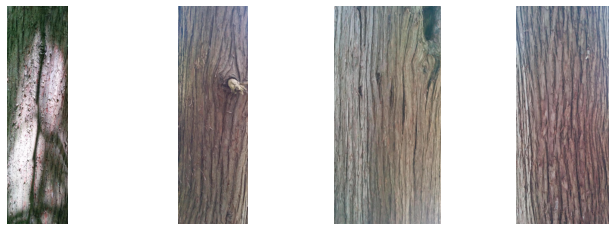

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 4

REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"

for arbre_id in dict_arbres.keys():
    try:
        dir_path = os.path.join(REPERTOIRE_ENTRAINEMENT,arbre_id+os.sep)
        liste_fichiers = os.listdir(os.path.join(REPERTOIRE_ENTRAINEMENT,arbre_id+os.sep))
        next_two_pics = [os.path.join(dir_path, fname) for fname in liste_fichiers[0:pic_index]]
        fig = plt.figure(figsize=(12,4))
        print("_"*90)
        print(arbre_id,dict_arbres[arbre_id].split('-')[1])
        for i, img_path in enumerate(next_two_pics):
            print(img_path)
            img = mpimg.imread(img_path)
            plt.subplot(1,pic_index,i+1)
            plt.imshow(img)
            plt.axis('Off')
        plt.show()
    except:
        continue


### Création de flux de lots de données pour l'entraînement

Chargeons ces images en mémoire en créant des `tf.data.dataset` à l'aide de l'utilitaire `tf.keras.utils.image_dataset_from_directory`. 

tf.data.Dataset prend en charge l'écriture de chaîne de traitement de données efficaces. L'itération se produit dans un flux continu, de sorte que l'ensemble complet de données  n'a pas besoin de tenir dans la mémoire.

In [22]:
import os
import numpy as np
import keras
print("Version de Keras:",keras.__version__)
import tensorflow as tf
print("Version de TensorFlow :",tf.__version__)

Version de Keras: 2.8.0
Version de TensorFlow : 2.8.0


In [23]:
REPERTOIRE_ENTRAINEMENT = "/content/lab_ecorces/train/"
REPERTOIRE_VALIDATION = "/content/lab_ecorces/val"
REPERTOIRE_TEST = "/content/lab_ecorces/test/"

TAILLE_LOT = 32
HAUTEUR_IMAGE = 150
LARGEUR_IMAGE = 150
TAILLE_IMAGE = (HAUTEUR_IMAGE, LARGEUR_IMAGE)
NOMBRE_CANAUX = 3

donnees_entrainement = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_ENTRAINEMENT,
                                                                   batch_size=TAILLE_LOT,
                                                                   image_size=TAILLE_IMAGE)

Found 3175 files belonging to 20 classes.


In [24]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
flux_images, flux_etiquettes = next(iter(donnees_entrainement))
print("Dimensions du flux d'images:",flux_images.shape)
print("Nombre d'images):",len(flux_images))
print("Dimensions du flux d'étiquettes:",flux_etiquettes.shape)
print("Nombre d'étiquettes):",len(flux_etiquettes))

Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Dimensions du flux d'images: (32, 150, 150, 3)
Nombre d'images): 32
Dimensions du flux d'étiquettes: (32,)
Nombre d'étiquettes): 32


In [25]:
liste_noms_classes = donnees_entrainement.class_names
print(liste_noms_classes)
nombre_de_classes = len(liste_noms_classes)
print('Nombre de classes:',nombre_de_classes)

['BOJ', 'BOP', 'CHR', 'EPB', 'EPN', 'EPO', 'EPR', 'ERR', 'ERS', 'FRA', 'HEG', 'MEL', 'ORA', 'OSV', 'PET', 'PIB', 'PIR', 'PRU', 'SAB', 'THO']
Nombre de classes: 20


In [26]:
donnees_validation = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_VALIDATION,
                                                                 batch_size=TAILLE_LOT,
                                                                 image_size=TAILLE_IMAGE)

Found 588 files belonging to 20 classes.


In [27]:
donnees_test = tf.keras.utils.image_dataset_from_directory(REPERTOIRE_TEST,
                                                           batch_size=TAILLE_LOT,
                                                           image_size=TAILLE_IMAGE)

Found 218 files belonging to 20 classes.


In [28]:
print("Nombre de lots de données d'entraînement: %d" % tf.data.experimental.cardinality(donnees_entrainement))
print("Nombre de lots de données de validation: %d" % tf.data.experimental.cardinality(donnees_validation))
print('Nombre de lots de données de test: %d' % tf.data.experimental.cardinality(donnees_test))


Nombre de lots de données d'entraînement: 100
Nombre de lots de données de validation: 19
Nombre de lots de données de test: 7


## Prétraitement des données

### Normalisation des données

In [29]:
couches_normalisation = keras.Sequential([
    keras.layers.Resizing(HAUTEUR_IMAGE,LARGEUR_IMAGE),
    keras.layers.Rescaling(1./255)
])

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

def pretraitement(jeu_donnees, melanger=False, normaliser=False):

    if melanger:
        jeu_donnees = jeu_donnees.shuffle(1000)
            
    # Normaliser les jeux de données
    if normaliser:
        jeu_donnees = jeu_donnees.map(lambda x, y: (couches_normalisation(x), y),
                                    num_parallel_calls=AUTOTUNE
                                    )
    
    # Utiliser des tampons de préextraction sur tous les jeux de données
    return jeu_donnees.prefetch(buffer_size=AUTOTUNE)

print("Fonction de prétraitement prête!")

Fonction de prétraitement prête!


#### Normalisation des données d'entraînement

In [31]:
print("Type Python de donnees_entrainement):",type(donnees_entrainement))
donnees_entrainement_normalisees = pretraitement(donnees_entrainement,
                                                 melanger=True,
                                                 normaliser=True)
print("Type Python donnees_entrainement_normalisees):",type(donnees_entrainement_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_entrainement_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))


Type Python de donnees_entrainement): <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type Python donnees_entrainement_normalisees): <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
2.549271e-05 0.9994976


In [ ]:
images, etiquettes = next(iter(donnees_entrainement_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))


#### Normalisation des données de validation

In [ ]:
print("Type Python de donnees_validation):",type(donnees_validation))
donnees_validation_normalisees = pretraitement(donnees_validation,
                                               melanger=False,
                                               normaliser=True)
print("Type Python donnees_validation_normalisees):",type(donnees_validation_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_validation_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))


In [ ]:
images, etiquettes = next(iter(donnees_validation_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))


#### Normalisation des données de test

In [ ]:
print("Type Python de donnees_test):",type(donnees_test))
AUTOTUNE = tf.data.AUTOTUNE
donnees_test = donnees_test.cache().prefetch(buffer_size=AUTOTUNE)
print("Type Python de donnees_test):",type(donnees_test))
donnees_test_normalisees = donnees_test.map(lambda x, y: (couches_normalisation(x), y))
print("Type Python de donnees_test_normalisees:",type(donnees_test_normalisees))
lot_images, lot_etiquettes = next(iter(donnees_test_normalisees))
premiere_image = lot_images[0]
# Notez que les valeurs des pixels sont maintenant dans l'intervalle `[0,1]`
print(np.min(premiere_image), np.max(premiere_image))


In [ ]:
images, etiquettes = next(iter(donnees_test_normalisees))
print("Dimensions flux d'images:",images.shape)
print("Nombre d'images:",len(images))
print("Dimensions flux d'étiquette:",etiquettes.shape)
print("Nombre d'étiquettes:",len(images))


## Création d'un modèle d'apprentissage par transfert

### Importation d'un modèle `inception` pré-entraîné sur `ImageNet`

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

# Charger les paramètres ou poids du modèle InceptionV3 pré-entraîné sur ImageNet
modele_preentraine = InceptionV3(weights='imagenet',
                                 input_shape = (HAUTEUR_IMAGE,LARGEUR_IMAGE,NOMBRE_CANAUX),
                                 include_top = False)


In [ ]:
print("Architecture du modèle préentraîné")
modele_preentraine.summary()

### Module d'extraction d'attributs visuels

#### Détermination de la couche de sortie et de la couche où débute le peaufinage

In [ ]:
modele_preentraine.trainable = True

# Combien de couches se trouvent dans le modèle pré-entraîné
nbr_couches_modele_preentraine = len(modele_preentraine.layers)
print("Nombre de couches dans le modèle pré-entraîné d'origine: ", nbr_couches_modele_preentraine)

# Comment obtenir l'index de la couche à partir de l'identifiant de la couche 
# https://www.thetopsites.net/article/50151157.shtml
liste_noms_de_couche = [couche.name for couche in modele_preentraine.layers]
nom_derniere_couche = liste_noms_de_couche[-1]
print("Nom de la dernière couche du modèle pré-entraîné complet:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné complet:",index_derniere_couche)

# Choix d'une nouvelle couche de sortie par essai / erreur
# cette étape assez laborieuse a été réalisée pour vous simplifier la tâche
nom_derniere_couche = 'mixed5'
print("Choix empirique de la dernière couche du modèle pré-entraîné:",nom_derniere_couche)
index_derniere_couche = liste_noms_de_couche.index(nom_derniere_couche)
print("Index de la dernière couche du modèle pré-entraîné choisie empiriquement:",index_derniere_couche)

# Choix de la dernière couche non-entraînable ou dernière couche « gelée » du modèle pré-entraîné
nom_derniere_couche_gelee = 'mixed3'
print("Choix empirique de la dernière couche non-entraînable:",nom_derniere_couche_gelee)
index_derniere_couche_gelee = liste_noms_de_couche.index(nom_derniere_couche_gelee)
print("Index de la dernière couche non-entraînable:",index_derniere_couche_gelee)
# Paufiner l'entraînement à partir de la dernière couche non-entraînable
debut_paufinage = index_derniere_couche_gelee
print("Nombre de couches gelées (non entraînables) dans le modèle préentraîné: ", debut_paufinage )
# Geler tous les couches avant la couche `debut_paufinage`
for couche in modele_preentraine.layers[:debut_paufinage]:
    couche.trainable =  False

print("Nombre de couches entraînables dans le modèle préentraîné: ", index_derniere_couche-debut_paufinage)
derniere_couche = modele_preentraine.get_layer(nom_derniere_couche)
print('Dimensions de la dernière couche: ', derniere_couche.output_shape)
sortie_derniere_couche = derniere_couche.output


### Ajout d'un module de *classification*

#### Perceptron multicouche

In [ ]:
# Ajouter une couche de régularisation par extinction de neurones (dropout)
sorties = layers.Dropout(0.1)(sortie_derniere_couche)
# Aplatir la couche de sortie en un vecteur (i.e. une dimension)
sorties = layers.Flatten()(sorties)
# Ajouter une couche entièrement connectée avec 1024 neurones cachés et l'activation ReLU
sorties = layers.Dense(1024, activation='relu')(sorties)
# Ajouter une couche de régularisation par extinction (dropout)
sorties = layers.Dropout(0.2)(sorties)      
# Ajouter une couche de sortie entièrement connectée de 20 neurones 
# avec l'activation softmax (exponentielle normalisée)
# *** IMPORTANT *** 20 classes => 20 neurones de sortie
sorties = layers.Dense(nombre_de_classes, activation='softmax')(sorties)           
modele_de_transfert = Model(modele_preentraine.input, sorties) 
print("Nombre de couches dans le modèle d'apprentissage par transfert: ", len(modele_de_transfert.layers))


In [ ]:
print("Architecture complète")
modele_de_transfert.summary()

In [ ]:
print("Nombre de paramètres entraînables dans le modèle de transfert: ",len(modele_de_transfert.trainable_variables))


## Compilation du modèle

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# D'après la documentation, tf.keras.utils.image_dataset_from_directory, encodera par défaut 
# un ensemble d'étiquettes de classes sous forme d'entiers allant de 1 au nombre de classes.
# Dans ce cas, le modèle doit être compilé avec une fonction d'erreur 'sparse_categorical_crossentropy'

modele_de_transfert.compile(optimizer = RMSprop(learning_rate=0.0001),
                            loss = 'sparse_categorical_crossentropy',
                            metrics = ['accuracy'])

print("Modèle compilé!")


## Entraînement du modèle

In [ ]:
nombre_iterations_de_base = 10
nombre_iterations_peaufinage = 30
nombre_total_iterations =  nombre_iterations_de_base + nombre_iterations_peaufinage

# Les fonctions de rappels sont passées au modèle via l'argument callbacks de .fit(...), 
# qui prend une liste de fonctions de rappels. 
liste_fonctions_rappels = [
    # Mémoriser le meilleur modèle
    keras.callbacks.ModelCheckpoint(
        filepath="IdEcorces_ResConv_TransAmpl.keras",
        save_best_only=True,
        # Surveiller l'erreur de validation
        monitor="val_loss"),
    # Arrêter l'entraînement quand son amélioration stagne
    keras.callbacks.EarlyStopping(
        # Surveiller l'exactitude de validation
        monitor='val_accuracy',
        # Arrêter l'entraînement quand l'exactitude stagne
        # depuis plus de 10 itérations (i.e., 11 itérations)
        patience=10,
        verbose=2),
    # Ajuster le taux taux d'apprentissage ou gain du gradient
    keras.callbacks.ReduceLROnPlateau(
        # Surveiller l'erreur de validation
        monitor='val_loss',
        # Diviser le taux d'apprentissage par 2 
        # lorsque la fonction de rappel est déclenchée
        factor=0.5,
        # La fonction de rappel est déclenchée quand l'erreur de validation 
        # a cessé de s'améliorer depuis 3 itérations
        patience=3,
        verbose=2) 
]

traces_entrainement = modele_de_transfert.fit(donnees_entrainement_normalisees,
                                              validation_data = donnees_validation_normalisees,
                                              epochs = nombre_total_iterations,
                                              callbacks=liste_fonctions_rappels,
                                              verbose = 2)


### Affichage des courbes d'entraînement

In [ ]:
# Dernière couche 'mixed5', dernière couche gelée 'mixed3'
# 40 itérations & amplification
# exactitude sur les données de test: de 80 à 85%
import matplotlib.pyplot as plt
exactitude_entrainement = traces_entrainement.history['accuracy']
exactitude_validation = traces_entrainement.history['val_accuracy']
erreur_entrainement = traces_entrainement.history['loss']
erreur_validation = traces_entrainement.history['val_loss']
nombre_iterations = range(len(exactitude_entrainement))
nombre_dor = 1.618
hauteur = 6
longueur = int(nombre_dor * hauteur)
plt.figure(figsize=(longueur,hauteur))
plt.plot(nombre_iterations, exactitude_entrainement, 'r', label='Exactitude entraînement')
plt.plot(nombre_iterations, exactitude_validation, 'b', label='Exactitude validation')
plt.title("Exactitude en entraînement & validation - apprentissage par transfert & amplification des données")
plt.legend(loc=0)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Exactitude")
plt.show()


### Évaluation du modèle avec les données de test

In [ ]:
erreur_test, exactitude_test = modele_de_transfert.evaluate(donnees_test_normalisees)
print("Exactitude sur les données de test: %0.2f" % exactitude_test)


### Résultats

Les résultats obtenus se situent dans une fourchette de 75 à 80%, ce qui est un bon départ considérant l'emploi de 1.5 Go de données (21 fois moins de données) que le jeu de données original de 32 Go.

### Analyse des résultats sur les données de test

#### Prédictions sur les données de test

Extraction des étiquettes prédites

In [ ]:
predictions = modele_de_transfert.predict(donnees_test_normalisees)
index_predictions = np.argmax(predictions, axis=1)
liste_etiquettes_predites = [(etiquette+1) for etiquette in index_predictions]
print(liste_etiquettes_predites)


Extraction des vraies étiquettes

In [ ]:
index_vraies_etiquettes = list(np.concatenate([etiquette for image, etiquette in donnees_test_normalisees], axis=0))
liste_vraies_etiquettes = [(etiquette+1) for etiquette in index_vraies_etiquettes]
print(liste_vraies_etiquettes)


Calcul de l'exactitude sur les données de test

In [ ]:
from sklearn import metrics

exactitude_test = metrics.accuracy_score(liste_vraies_etiquettes, liste_etiquettes_predites)
print("Exactitude:   %0.2f" % exactitude_test)


#### Affichage d'une matrice de confusion

In [ ]:
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python

import itertools

def afficher_matrice_de_confusion(matrice_confusion_brute, classes,
                          normalisation=False,
                          titre='Matrice de confusion',
                          carte_des_couleurs=plt.cm.Blues):
    plt.figure(figsize=(14,12))
    plt.imshow(matrice_confusion_brute, interpolation='nearest', cmap=carte_des_couleurs)
    plt.title(titre)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalisation:
        matrice_confusion_brute = matrice_confusion_brute.astype('float') / matrice_confusion_brute.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    seuil = matrice_confusion_brute.max() / 2.
    for i, j in itertools.product(range(matrice_confusion_brute.shape[0]), range(matrice_confusion_brute.shape[1])):
        plt.text(j, i, matrice_confusion_brute[i, j],
                 horizontalalignment="center",
                 color="white" if matrice_confusion_brute[i, j] > seuil else "black")

    plt.tight_layout()
    plt.ylabel('Vraies étiquettes')
    plt.xlabel('Étiquettes prédites')

    
print("Code affichage matrice de confusion")


In [ ]:
matrice_confusion_brute = metrics.confusion_matrix(liste_vraies_etiquettes, liste_etiquettes_predites)
afficher_matrice_de_confusion(matrice_confusion_brute, classes=liste_noms_classes)


#### Rapport de classification

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(liste_vraies_etiquettes, liste_etiquettes_predites, target_names=liste_noms_classes))


In [ ]:
print("Fin de l'exécution du carnet IPython")